In [5]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

## Imports

In [6]:
import os
import pandas as pd
import numpy as np
import talib as ta
from data_preparation import PreProcess, PivotLevels
from db_access import StockHistory, ExportToParquet, ExportToPickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

pd.options.display.max_columns = 200

## Preparacao dos datasets

O código abaixo utiliza os arquivos parquet previamente extraídos do banco de dados.

In [ ]:
pre_process = PreProcess()
parquet_exporter = ExportToParquet()
pickle_exporter = ExportToPickle()

raw_file_path = os.environ.get("RAW_DATA_PATH")
data_file_path = os.environ.get("DATASET_PATH")
model_base_path = os.environ.get("MODELS_PATH")
str_conn = os.environ.get("STR_CON")
stride_coef_ang = 1

# Colunas que serão usadas MinMaxScaler
columns_to_scale = ['close', 'open', 'high', 'low', 'rsi', 'macd', 'macdsignal', 'macdhist', 'slowk', 'slowd', 'willr', 'mfi',
                    'coef_ang_volume', 'var_volume', 'diff_volume_vol_med',
                    'diff_close_r1', 'diff_close_r2', 'diff_close_r3', 'diff_close_s1', 'diff_close_s2', 'diff_close_s3',
                    'diff_willr_20', 'diff_willr_80', 'dif_mfi_20', 'diff_mfi_80', 
                    'diff_rsi_70', 'diff_k_d']
# Colunas com sinal de negociação. O dataframe usado pelo modelo terá uma série temporal e colunas com sinal de negociação. A coluna com a série temporal
# será passada para autoencoder, que irá gerar um vetor que representa a série, este vetor será concatenado com as colunas de sinal e passarão por uma MLP
# que fará a classificação do ativo
signal_cols = ['DR3', 'M2', 'MA', 'MB', 'N/D', 'N1', 'N2', 'NM', 
               'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLTAKURI', 'CDLHANGINGMAN', 'CDLEVENINGDOJISTAR', 'CDL3OUTSIDE', 'CDLONNECK', 'CDLHAMMER', 'CDLHARAMICROSS',
               'diff_volume_vol_med', 'diff_close_r1', 'diff_close_r2', 'diff_close_r3', 'diff_close_s1',
               'diff_close_s2', 'diff_close_s3', 'coef_ang_volume', 'var_volume',
               'diff_willr_20', 'diff_willr_80', 'dif_mfi_20', 'diff_mfi_80', 'diff_rsi_70', 'diff_k_d',
               'volatiliade', 'coef_ang_close', 'coef_ang_volat', 'coef_ang_macdhist', 'coef_ang_rsi', 'coef_ang_mfi']
splited_cols = ['close', 'open', 'high', 'low']
# Colunas que não precisam passar pelo MinMaxScaler
columns_to_pop = ['ticker', 'DR3', 'M2', 'MA', 'MB', 'N/D', 'N1', 'N2', 'NM', 
                  'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLTAKURI', 'CDLHANGINGMAN', 'CDLEVENINGDOJISTAR', 'CDL3OUTSIDE', 'CDLONNECK', 'CDLHAMMER', 'CDLHARAMICROSS',
                  'volatiliade', 'coef_ang_close', 'coef_ang_volat', 'coef_ang_macdhist', 'coef_ang_rsi', 'coef_ang_mfi']

path_content = os.listdir(raw_file_path)
# Filtra os arquivos parquet do diretório
path_content = [file for file in path_content if file.endswith(".parquet")]

# Faz o one hot encoder do mercado onde o emissor do ativo é negociado
dbo = StockHistory(str_conn)
markets = dbo.select_markets()
one_hot = OneHotEncoder(sparse=False)
one_hot.fit(markets.values)

for file in path_content:
    print(f"Processando arquivo: {raw_file_path}/{file}")
    df_raw = pd.read_parquet(os.path.join(raw_file_path, file))
    market_one_hot = pd.DataFrame(one_hot.transform(df_raw['market'].values.reshape(-1,1)), columns = one_hot.categories_[0])
    df_raw = pd.concat([df_raw.reset_index(), market_one_hot], axis=1).set_index('index')
    df_raw.set_index("dt_price", drop=False, inplace=True)

    # Calcula os indicadores técnicos definidos nas estratégias para cada ativo
    for strategy_name, strategy, df_tech in pre_process.calculate_strategy("strategies.json", df_raw):
        window_size = strategy["historic_period"]
        stride = strategy["stride"]
        profit_period = strategy["profit_period"]
        profit = strategy["profit"]

        # Ajusta d valor do ROC
        df_tech['roc'] = df_tech['roc']/100
        # Calcula a volatilidade do ativo no periodo window_size
        df_tech['volatiliade'] = df_tech['roc'].rolling(window=window_size).std()
        # Calcula a variacao do volume
        df_tech['var_volume'] = ta.ROC(df_tech['volume'], 1)/100
        df_tech[f'vol_med_{window_size}_days'] = df_tech['volume'].rolling(window=window_size).mean()
        df_tech['diff_volume_vol_med'] = df_tech['volume']/df_tech[f'vol_med_{window_size}_days']-1

        # Calcula os Pivot Levels
        pivot_levels = PivotLevels(high=df_tech['high'], low=df_tech['low'], close=df_tech['close'])

        # Diferenca entre os Pivot Levels e o preco de fechamento
        df_tech['diff_close_r1'] = df_tech['close'] - pivot_levels.R1
        df_tech['diff_close_r2'] = df_tech['close'] - pivot_levels.R2
        df_tech['diff_close_r3'] = df_tech['close'] - pivot_levels.R3
        df_tech['diff_close_s1'] = df_tech['close'] - pivot_levels.S1
        df_tech['diff_close_s2'] = df_tech['close'] - pivot_levels.S2
        df_tech['diff_close_s3'] = df_tech['close'] - pivot_levels.S3

        # Caclula o coeficiente angular da regressao do preco de fechamento e adiciona ao dataframe de treinamento
        df_tech['coef_ang_close'] = pre_process.linear_regression_slope(df_tech['close'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_volume'] = pre_process.linear_regression_slope(df_tech['volume'], window_size=window_size, stride=stride_coef_ang)
        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        df_tech['coef_ang_volat'] = pre_process.linear_regression_slope(df_tech['volatiliade']*100, window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_macdhist'] = pre_process.linear_regression_slope(df_tech['macdhist'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_rsi'] = pre_process.linear_regression_slope(df_tech['rsi'], window_size=window_size, stride=stride_coef_ang)
        df_tech['coef_ang_mfi'] = pre_process.linear_regression_slope(df_tech['mfi'], window_size=window_size, stride=stride_coef_ang)

        # Remove os valores nulos do DataFrame
        df_tech.dropna(inplace=True)

        # Cria um dataframe auxilizar para armazenar as colunas que serao usadas no modelo, mas nao precisam ser redimensionadas 
        df_aux = pd.DataFrame()
        for col in columns_to_pop:
            df_aux[col] = df_tech.pop(col)

        scaler = MinMaxScaler().fit(df_tech[columns_to_scale])
        transformed_data = scaler.transform(df_tech[columns_to_scale])
        df_tech = pd.concat([df_aux.reset_index(), pd.DataFrame(transformed_data, columns=scaler.get_feature_names_out())], axis=1).set_index('dt_price', drop=False)

        # Formata o dataset para ser usado no modelo
        df_model = pre_process.format_dataset(df_raw, df_tech, window_size, stride, profit_period, profit, None, signal_cols, splited_cols)

        # Exporta o data set como um arquivo parquet
        parquet_exporter.export(df_model, os.path.join(data_file_path, strategy_name), file.split('.')[0])


In [33]:
df_model.head()

,ticker,dt_price_start,dt_price_ends,shape,series,price_shape,price_cols,DR3,M2,MA,MB,N/D,N1,N2,NM,CDLMORNINGSTAR,CDLSHOOTINGSTAR,CDLTAKURI,CDLHANGINGMAN,CDLEVENINGDOJISTAR,CDL3OUTSIDE,CDLONNECK,CDLHAMMER,CDLHARAMICROSS,diff_volume_vol_med,diff_close_r1,diff_close_r2,diff_close_r3,diff_close_s1,diff_close_s2,diff_close_s3,coef_ang_volume,var_volume,diff_willr_20,diff_willr_80,dif_mfi_20,diff_mfi_80,diff_rsi_70,diff_k_d,volatiliade,coef_ang_close,coef_ang_volat,coef_ang_macdhist,coef_ang_rsi,coef_ang_mfi,profit,label
0,NTCO3,2013-04-29,2013-07-03,"(45, 8)","[0.4966242353251218, 0.6453759798740366, 0.613...","(45, 4)","[0.22422729890574009, 0.21560338201383547, 0.2...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.094559,0.931608,0.931608,0.930775,0.042763,0.042763,0.049933,0.524482,0.046626,0.205128,0.205128,0.330788,0.330788,0.310516,0.363674,0.016773,-0.041607,-0.008663,-0.006823,-0.557788,-0.866356,-0.037551,0
1,NTCO3,2013-05-07,2013-07-11,"(45, 8)","[0.5652557528159028, 0.6645750501635191, 0.629...","(45, 4)","[0.234785947398733, 0.22405841660261336, 0.231...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106449,0.876155,0.876155,0.866995,0.097039,0.097039,0.107190,0.509703,0.085909,0.367188,0.367188,0.507152,0.507152,0.380720,0.633887,0.016197,-0.058149,-0.008349,-0.004774,-0.557066,-0.704723,-0.013299,0
2,NTCO3,2013-05-14,2013-07-18,"(45, 8)","[0.5225209709321496, 0.6711010435312528, 0.640...","(45, 4)","[0.23190631599155306, 0.24019984627209837, 0.2...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098942,0.829020,0.829020,0.824216,0.106908,0.106908,0.126498,0.484147,0.067002,0.138889,0.138889,0.232529,0.232529,0.224329,0.361180,0.016142,-0.076744,-0.007514,-0.002722,-0.579570,-0.575429,0.014069,0
3,NTCO3,2013-05-21,2013-07-25,"(45, 8)","[0.679967502773535, 0.7005576784634727, 0.6629...","(45, 4)","[0.2564791706661548, 0.2582628747117601, 0.255...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169249,0.892791,0.892791,0.854550,0.180921,0.180921,0.171105,0.494204,0.097142,0.523148,0.523148,0.420941,0.420941,0.423714,0.534809,0.016717,-0.077271,-0.005717,0.000045,-0.406749,-0.408634,-0.072606,0
4,NTCO3,2013-05-28,2013-08-01,"(45, 8)","[0.5970190429031635, 0.7077140324232241, 0.682...","(45, 4)","[0.2545594163947015, 0.2636433512682551, 0.262...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132140,0.842884,0.842884,0.846772,0.072368,0.072368,0.095206,0.473585,0.065650,0.322222,0.322222,0.354012,0.354012,0.334660,0.381530,0.016555,-0.058004,-0.002878,0.004516,-0.073913,-0.044561,0.043549,1


In [ ]:
pre_process = PreProcess()
random_seed = 42
test_size = 0.15

pre_process.create_train_test_dataset("strategies.json", test_size, random_seed, [])

## Definição da arquitetura do modelo
O modelo será composto por duas redes neurais:<br>
1. Uma LSTM, que tem como objetivo processar a série temporal do preço do ativo e seus respectivos indicadores técnicos
2. Uma MLP que receberá a saída da LSTM e os demais sinais de negociação calculados na etapa de preparação das features.<br>
<p>A saída das duas redes será concatenada e este conjunto de features será processado por camadas dense até gerar a saída do modelo que será 1 se a ação for classificada como "ação que irá se valorizar mais de X% em Y dias" ou 0 caso contrário.</p>

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_32_input (InputLayer)    [(None, 38)]         0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 38)           1482        ['dense_32_input[0][0]']         
                                                                                                  
 dropout_26 (Dropout)           (None, 38)           0           ['dense_32[0][0]']               
                                                                                                  
 input_7 (InputLayer)           [(None, 45, 8)]      0           []                               
                                                                                           

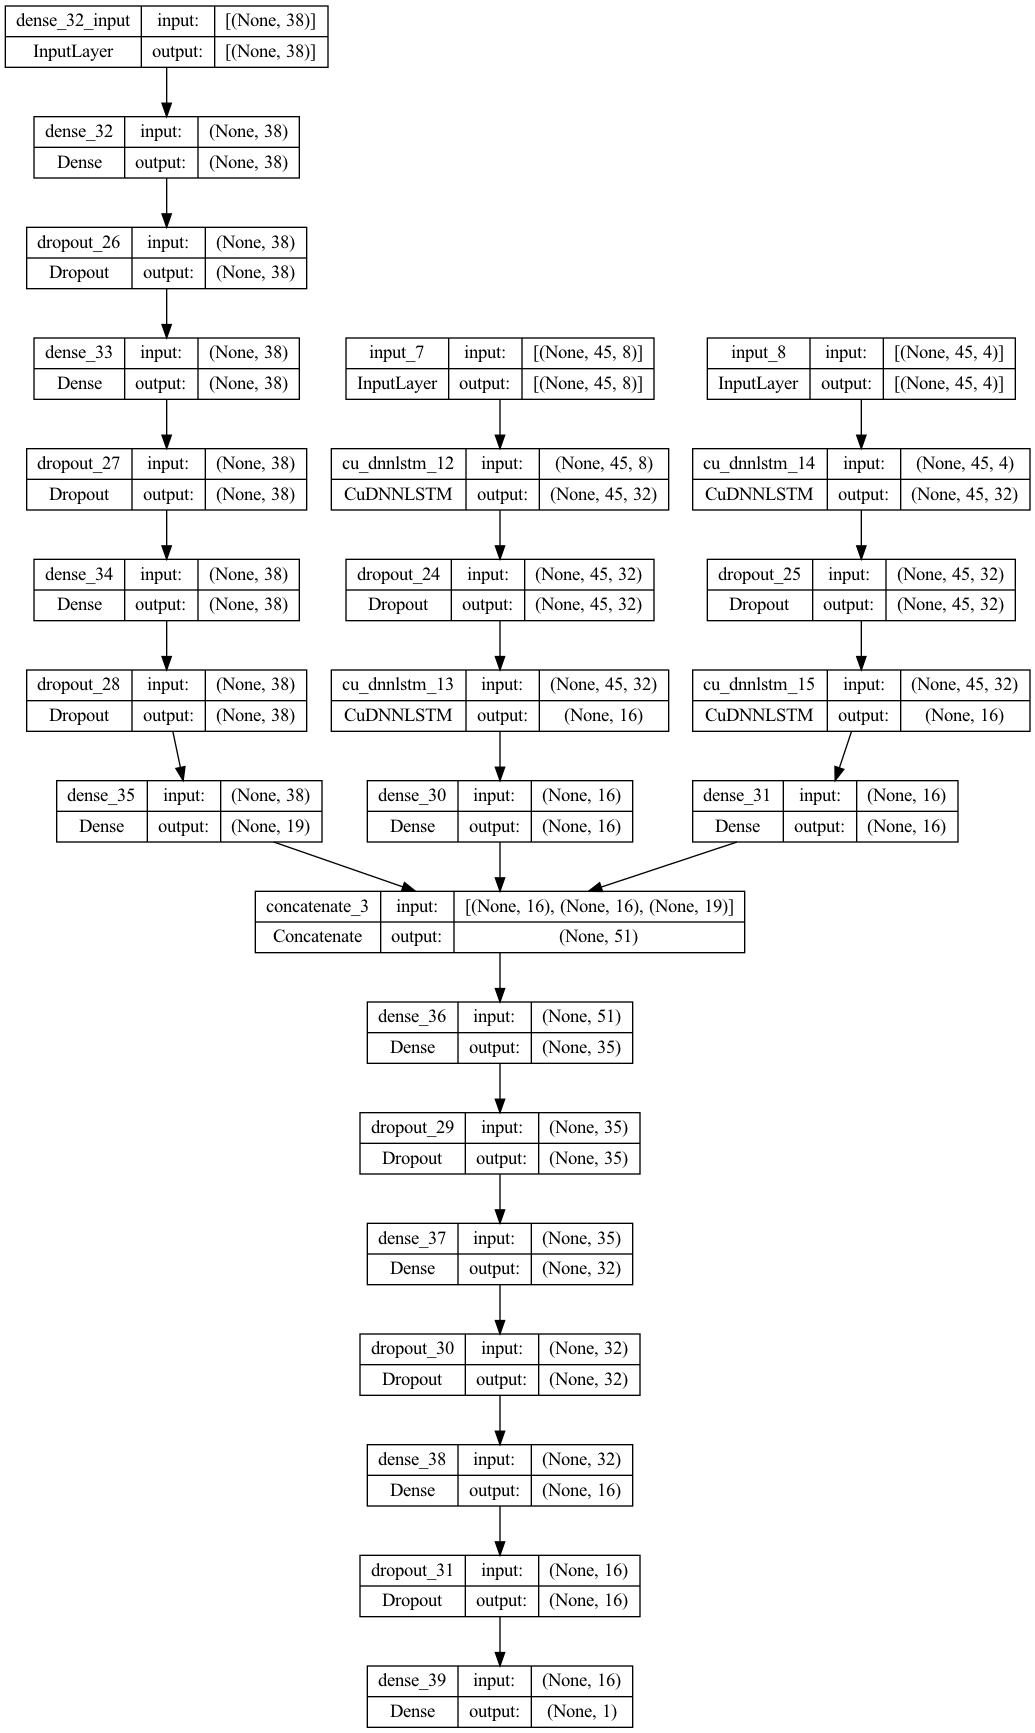

In [44]:
from keras.layers import CuDNNLSTM, Input, RepeatVector, TimeDistributed, Dense, concatenate, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras.optimizers import Adam


preprocess = PreProcess()
metric = "AUC"

# Define os callback que serão usados no treinamento do modelo
cb_early_stopping = EarlyStopping(monitor=f'val_{metric.lower()}', 
                                  patience=20, 
                                  min_delta=0.0005, 
                                  mode='max')

cb_model_checkpoint = ModelCheckpoint("data/tf_models/multi_input/model-{epoch:02d}-{val_auc:.4f}.h5",
                                      monitor=f'val_{metric.lower()}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

cb_reduce_lr_on_plateu = ReduceLROnPlateau(monitor=f"val_{metric.lower()}",
                                           factor=0.1,
                                           patience=20,
                                           verbose=0,
                                           mode="auto",
                                           min_delta=0.0001,
                                           cooldown=0,
                                           min_lr=0.0000001)
                                            
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_IndTec_Train = np.array([val[0] for val in df_train.values])
X_IntTec_Test = np.array([val[0] for val in df_test.values])

X_Price_Train = np.array([val[1] for val in df_train.values])
X_Price_Test = np.array([val[1] for val in df_test.values])

Y_train = df_train.pop('label')
Y_test = df_test.pop('label')

X_SIG_Train = df_train[df_train.columns[~df_train.columns.isin(['series', 'price_cols'])]].values
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series', 'price_cols'])]].values

# Rede LSTM para tratar os indicadores tecnicos
input_ts_data = Input((X_IndTec_Train.shape[1], X_IndTec_Train.shape[2]) )
lstm_layer = CuDNNLSTM(32, input_shape=X_IndTec_Train.shape, return_sequences=True)(input_ts_data)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = CuDNNLSTM(16, input_shape=X_IndTec_Train.shape)(lstm_layer)
lstm_layer = Dense(16, activation="relu")(lstm_layer)
model_lstm = Model(input_ts_data, lstm_layer)

# Rede LSTM para tratar a serie historica de precos
input_price_data = Input((X_Price_Train.shape[1], X_Price_Train.shape[2]) )
lstm_price_layer = CuDNNLSTM(32, input_shape=X_Price_Train.shape, return_sequences=True)(input_price_data)
lstm_price_layer = Dropout(0.2)(lstm_price_layer)
lstm_price_layer = CuDNNLSTM(16, input_shape=X_Price_Train.shape)(lstm_price_layer)
lstm_price_layer = Dense(16, activation="relu")(lstm_price_layer)
model_lstm_price = Model(input_price_data, lstm_price_layer)

# Rede MLP para tratar os sinais de negociação
mlp = Sequential()
mlp.add(Dense(X_SIG_Train.shape[1], input_dim = X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1], activation="relu"))
mlp.add(Dropout(0.2))
mlp.add(Dense(X_SIG_Train.shape[1]//2, activation="relu"))

# Concatena os modelos
final_layers = concatenate([model_lstm.output, model_lstm_price.output ,mlp.output])
final_layers = Dense(35, activation="relu")(final_layers)
final_layers = Dropout(0.2)(final_layers)
final_layers = Dense(32, activation="relu")(final_layers)
final_layers = Dropout(0.2)(final_layers)
final_layers = Dense(16, activation="relu")(final_layers)
final_layers = Dropout(0.2)(final_layers)
final_layers = Dense(1, activation='sigmoid')(final_layers)

optimizer = Adam(learning_rate=0.002)
full_model = Model(inputs=[model_lstm.input, model_lstm_price.input, mlp.input], outputs=final_layers)

full_model.compile(loss='binary_crossentropy', 
                    optimizer=optimizer,
                    metrics=[metric])
full_model.summary()
plot_model(full_model, 'images/multi_input_model.png', show_shapes=True)


In [45]:
batch_size = 64
epochs = 200

full_model.fit(
	x=[X_IndTec_Train, X_Price_Train, X_SIG_Train], y=Y_train,
	validation_data=([X_IntTec_Test, X_Price_Test, X_SIG_Test], Y_test),
    callbacks=[cb_early_stopping, cb_model_checkpoint, cb_reduce_lr_on_plateu],
	epochs=epochs, batch_size=batch_size)


Epoch 1/200


2023-01-30 17:33:28.323235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - ETA: 0s - loss: 0.6704 - auc: 0.5176

2023-01-30 17:36:43.233940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_auc improved from -inf to 0.50605, saving model to data/tf_models/multi_input/model-01-0.5061.h5
857/857 [==============================] - 216s 245ms/step - loss: 0.6704 - auc: 0.5176 - val_loss: 0.6711 - val_auc: 0.5061 - lr: 0.0020
Epoch 2/200
857/857 [==============================] - ETA: 0s - loss: 0.6686 - auc: 0.5285
Epoch 2: val_auc improved from 0.50605 to 0.51010, saving model to data/tf_models/multi_input/model-02-0.5101.h5
857/857 [==============================] - 225s 262ms/step - loss: 0.6686 - auc: 0.5285 - val_loss: 0.6697 - val_auc: 0.5101 - lr: 0.0020
Epoch 3/200
857/857 [==============================] - ETA: 0s - loss: 0.6682 - auc: 0.5308
Epoch 3: val_auc improved from 0.51010 to 0.51499, saving model to data/tf_models/multi_input/model-03-0.5150.h5
857/857 [==============================] - 222s 260ms/step - loss: 0.6682 - auc: 0.5308 - val_loss: 0.6699 - val_auc: 0.5150 - lr: 0.0020
Epoch 4/200
857/857 [==============================] - ETA: 0s - 

In [47]:
df_test.head()

,series,DR3,M2,MA,MB,N/D,N1,N2,NM,CDLMORNINGSTAR,CDLSHOOTINGSTAR,CDLTAKURI,CDLHANGINGMAN,CDLEVENINGDOJISTAR,CDL3OUTSIDE,CDLONNECK,CDLHAMMER,CDLHARAMICROSS,diff_volume_vol_med,diff_close_r1,diff_close_r2,diff_close_r3,diff_close_s1,diff_close_s2,diff_close_s3,coef_ang_volume,var_volume,diff_willr_20,diff_willr_80,dif_mfi_20,diff_mfi_80,diff_rsi_70,diff_k_d,volatiliade,coef_ang_close,coef_ang_volat,coef_ang_macdhist,coef_ang_rsi,coef_ang_mfi
0,"[[0.13959680486877135, 0.15532879818594103, 0....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054244,0.916503,0.916503,0.918735,0.073643,0.073643,0.075817,0.391949,0.063982,0.639098,0.639098,0.525432,0.525432,0.618718,0.526757,0.017688,0.051372,-0.001760,0.002548,0.293180,0.079417
1,"[[0.39786991251426396, 0.39002267573696137, 0....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051259,0.975442,0.975442,0.976744,0.019380,0.019380,0.020078,0.446064,0.081612,0.445946,0.445946,0.619676,0.619676,0.575506,0.373781,0.005206,0.003577,-0.003897,0.002131,-0.139804,0.282769
2,"[[0.6550019018638263, 0.6651549508692366, 0.65...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039815,0.924361,0.924361,0.902535,0.184755,0.184755,0.150734,0.422245,0.080328,0.957983,0.957983,0.562692,0.562692,0.630656,0.486139,0.017734,-0.059991,-0.003898,0.000780,-0.091752,-0.175181
3,"[[0.19399011030810198, 0.211262282690854, 0.20...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077143,0.963654,0.963654,0.953227,0.089147,0.089147,0.072221,0.399549,0.114925,0.339130,0.339130,0.456788,0.456788,0.579392,0.509027,0.027369,0.001924,0.013291,0.001858,0.231490,0.642147
4,"[[0.712438189425637, 0.7339380196523054, 0.731...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041758,0.844794,0.844794,0.852365,0.118863,0.118863,0.129158,0.409690,0.039402,0.801020,0.801020,0.717151,0.717151,0.780273,0.416479,0.011160,0.060763,-0.004140,0.007001,0.572300,0.936025


In [46]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
from keras.utils import plot_model

model = load_model("data/tf_models/multi_input/model-43-0.5435.h5") # model-53-0.5709.h5

preprocess = PreProcess()
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Test = np.array([val[0] for val in df_test.values])
Y_test = df_test.pop('label')
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

Y_test_predict = (model.predict([X_TS_Test, X_SIG_Test]).flatten() > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test.values, Y_test_predict):.4f}")


ValueError: in user code:

    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_11" expects 3 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 45, 12) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 38) dtype=float32>]


In [ ]:
# model-53-0.5709.h5
# Accuracy: 0.6111
# Matriz de confusao:
#  [[5427  499]
#  [3299  541]]
# Precision: 0.5202
# Recall: 0.1409
# F1 Score: 0.2217